In [7]:
import os
import sys

# SPINQUANT_HOME = os.environ.get("SPINQUANT_HOME", "/opt/spinquant")
SPINQUANT_HOME = '/home/donghweeson/workspace/SpinQuant' # /home/donghweeson/workspace/SpinQuant

os.chdir(SPINQUANT_HOME)
print("Changed working directory to:", os.getcwd())

sys.argv = [
  "python",
  "--input_model", "models/llama2-7b",
  "--do_train", "False",
  "--do_eval", "True",
  "--per_device_eval_batch_size", "4",
  "--model_max_length", "2048",
  "--fp16", "True",
  "--bf16", "False",
  "--save_safetensors", "False",
  "--w_bits", "4",
  "--a_bits", "16",
  "--k_bits", "4",
  "--v_bits", "4",
  "--w_clip",
  "--a_asym",
  "--k_asym",
  "--v_asym",
  "--rotate",
  "--k_groupsize", "128",
  "--v_groupsize", "128",
  "--load_qmodel_path", "saved_models/llama2-7b/a16w4kv4-vasym.pt",
  "--optimized_rotation_path", "rotation_llama-2-7b/a16w4kv4-vsym/R.bin"
]

Changed working directory to: /home/donghweeson/workspace/SpinQuant


In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import datetime
from logging import Logger

import torch
import torch.distributed as dist
from transformers import LlamaTokenizerFast
import transformers
from eval_utils.main import ptq_model
from eval_utils.modeling_llama import LlamaForCausalLM
from utils import data_utils, eval_utils, utils
from utils.process_args import process_args_ptq

log: Logger = utils.get_logger("spinquant")

import evaluate
from lm_eval import evaluator
from lm_eval.utils import make_table

from utils.quant_utils import find_qlayers, ActQuantWrapper
from functools import partial
import pickle

from utils.profile import (
  measure, profile, get_profiler, 
  get_profiled_df, plot_profiled_df,
  run_profile
)
import pstats
import importlib

import pandas as pd
pd.set_option('display.max_colwidth', 100)

from matplotlib import pyplot as plt

In [11]:
task_names = ['hellaswag', 'arc_easy','arc_challenge', 'winogrande', 'openbookqa', "wikitext"]
# task_names = ['openbookqa']
# task_names = ['arc_easy']

CUDA_DEVICES = list(map(str.strip, os.environ.get("CUDA_VISIBLE_DEVICES", "0").split(",")))
FIRST_GPU_ID = int(CUDA_DEVICES[0])
GPU_ID = 0

In [15]:
# dist.init_process_group(backend="nccl", timeout=datetime.timedelta(hours=8))
model_args, training_args, ptq_args = process_args_ptq()
print("------- ARGS ----------")
print("-----model args-----")
print(model_args)
print("------train args-------")
print(training_args)
print("-------- ptq args ---------")
print(ptq_args)
print("------- ARGS END ----------")

config = transformers.AutoConfig.from_pretrained(
    model_args.input_model, token=model_args.access_token, attn_implementation="eager"
)
# Llama v3.2 specific: Spinquant is not compatiable with tie_word_embeddings, clone lm_head from embed_tokens
process_word_embeddings = False
if config.tie_word_embeddings:
    config.tie_word_embeddings = False
    process_word_embeddings = True
dtype = torch.bfloat16 if training_args.bf16 else torch.float16
model = LlamaForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_args.input_model,
    config=config,
    torch_dtype=dtype,
    token=model_args.access_token,
)
if process_word_embeddings:
    model.lm_head.weight.data = model.model.embed_tokens.weight.data.clone()
model.cuda()

model = ptq_model(ptq_args, model, model_args)

------- ARGS ----------
-----model args-----
ModelArguments(input_model='models/llama2-7b', output_rotation_path='test-output', optimized_rotation_path='rotation_llama-2-7b/a16w4kv4-vsym/R.bin', access_token=None)
------train args-------
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
cache_dir=None,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]
2025-08-08:11:56:01,643 INFO     [utils.py:132] GPU memory (from rotate_model): 15.97 -> 12.47 GB (-3.50 GB)
Rotating: 100%|██████████| 32/32 [02:28<00:00,  4.65s/layer]
2025-08-08:11:58:30,874 INFO     [utils.py:132] GPU memory (from ptq_model): 13.27 -> 0.03 GB (-13.23 GB)
/home/donghweeson/.conda/envs/spinq/lib/python3.10/site-packages/transformers/modeling_utils.py:4713: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Load quantized model from  saved_models/llama2-7b/a16w4kv4-vasym.pt


In [16]:
model.seqlen = training_args.model_max_length
log.info("Model PTQ completed {}".format(model))
log.info("Start to load tokenizer...")
tokenizer = LlamaTokenizerFast.from_pretrained(
    pretrained_model_name_or_path=model_args.input_model,
    cache_dir=training_args.cache_dir,
    model_max_length=training_args.model_max_length,
    padding_side="right",
    use_fast=True,
    add_eos_token=False,
    add_bos_token=False,
    token=model_args.access_token,
)
log.info("Complete tokenizer loading...")
# model.config.use_cache = False
# dataset_ppl = eval_utils.evaluator(model, testloader, utils.DEV, ptq_args)
# log.info("wiki2 ppl is: {}".format(dataset_ppl))
# dist.barrier()

2025-08-08 11:58:46,907 - spinquant - INFO - Model PTQ completed LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (k_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (v_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 4 (Asymmetric Per-Token)
            (module): Linear(in_features=409

In [ ]:
# import gc
# model.cpu()
# del input_ids, past_key_values
# gc.collect()

# torch.cuda.empty_cache()
# torch.cuda.memory_allocated()

In [17]:
past_seq_len = 0
target_seq_len = 32
batch_size = 2

In [18]:
os.makedirs("./prof", exist_ok=True)

In [13]:
batch_size = [1, 2, 4]
past_seq_len = [8, 16, 32, 64, 128]
seq_len = [8, 16, 32, 64, 128]

for bs in batch_size:
  # prefill
  for sl in seq_len:
    print(f"PREFILL: bs {bs}, sl {sl}")
    run_profile(model, bs, 0, sl, "cpu", f"./prof/bs{bs}_sl{sl}_prf.png") 
  
  # generate
  for sl in past_seq_len:
    print(f"GENERATE: bs {bs}, sl {sl}")
    run_profile(model, bs, sl, 1, "cpu", f"./prof/bs{bs}_sl{sl}_gen.png")

2025-08-08:11:29:33,289 WARNING  [logging.py:328] We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/internal/generation_utils#transformers.Cache)


PREFILL: bs 1, sl 8
Warmup...


KeyboardInterrupt: 

PREFILL: bs 1, sl 8


2025-08-08:11:59:23,279 WARNING  [logging.py:328] We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/internal/generation_utils#transformers.Cache)


Warmup...


2025-08-08:11:59:23,678 WARNING  [logging.py:328] Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0737161636353 0.0678553581238
top.apply_rope                                                                   32         0.0254862308502 0.0198230743408
top.apply_rope.k_head_quantize                                                   32         0.0142838954926 0.0120568275452
top.vproj                                                                        32         0.0139455795288 0.0116264820099
top.apply_rope.k_head_quantize.find_params                                       32         0.0095276832581 0.0000000000000
top.vproj.find_params                                                            32         0.0083882808685 0.0076940059662
top.vproj.find_params.find_params_per_token_groupwise                            32         0.0076940059662 0.000

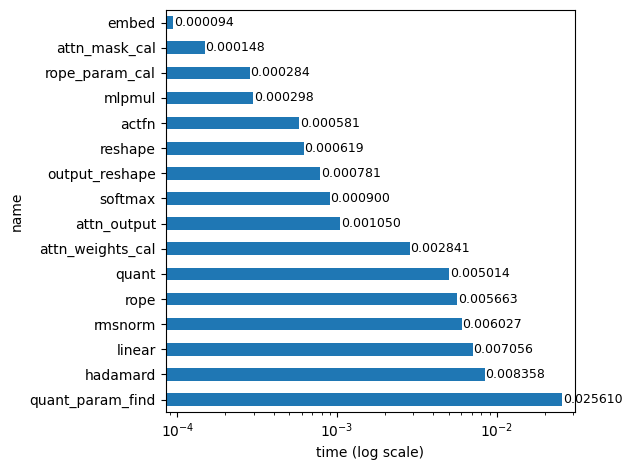

PREFILL: bs 1, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0732145309448 0.0673568248749
top.apply_rope                                                                   32         0.0248517990112 0.0192687511444
top.vproj                                                                        32         0.0139546394348 0.0116267204285
top.apply_rope.k_head_quantize                                                   32         0.0138320922852 0.0116546154022
top.apply_rope.k_head_quantize.find_params                                       32         0.0091643333435 0.0000000000000
top.vproj.find_params                                                            32         0.0083906650543 0.0076901912689
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


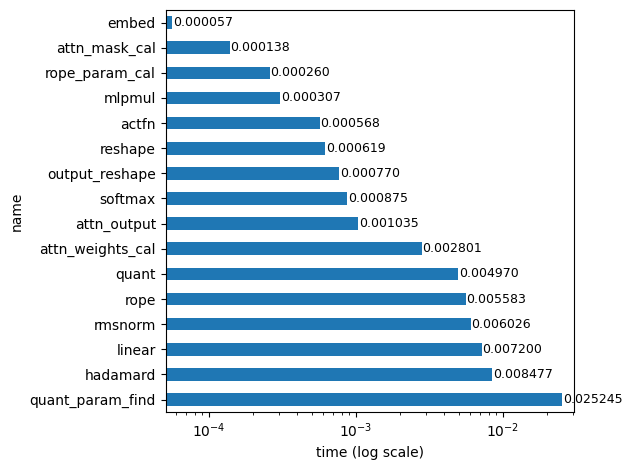

PREFILL: bs 1, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0742309093475 0.0682861804962
top.apply_rope                                                                   32         0.0248858928680 0.0192170143127
top.vproj                                                                        32         0.0141007900238 0.0117571353912
top.apply_rope.k_head_quantize                                                   32         0.0137751102448 0.0115959644318
top.apply_rope.k_head_quantize.find_params                                       32         0.0090935230255 0.0000000000000
top.vproj.find_params                                                            32         0.0084588527679 0.0077602863312
top.downproj                                                                     3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


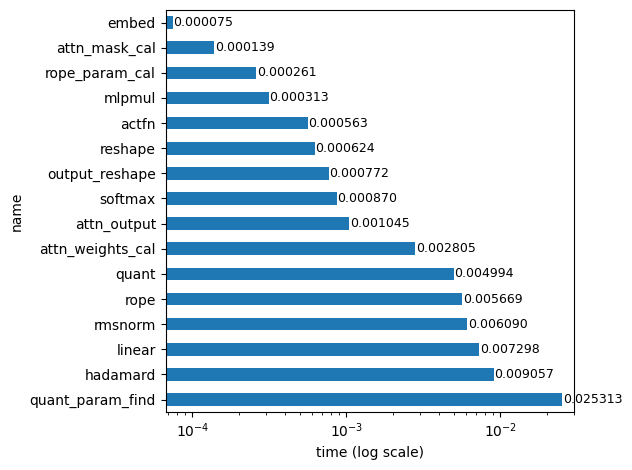

PREFILL: bs 1, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0759501457214 0.0699484348297
top.apply_rope                                                                   32         0.0271265506744 0.0214555263519
top.apply_rope.k_head_quantize                                                   32         0.0160014629364 0.0136454105377
top.vproj                                                                        32         0.0141646862030 0.0118305683136
top.apply_rope.k_head_quantize.find_params                                       32         0.0090777873993 0.0000000000000
top.vproj.find_params                                                            32         0.0085034370422 0.0078003406525
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


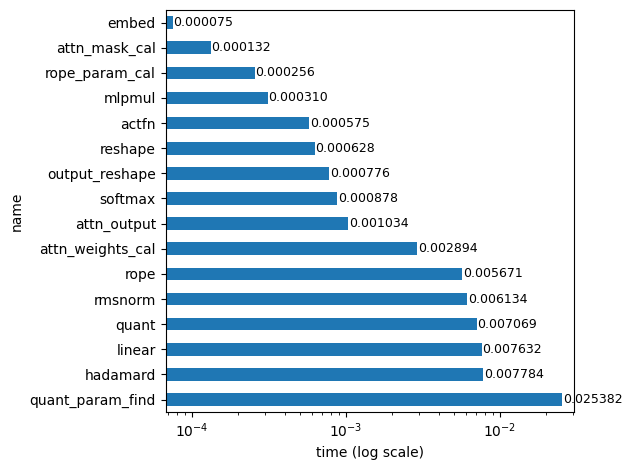

PREFILL: bs 1, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0739917755127 0.0683834552765
top.apply_rope                                                                   32         0.0240826606750 0.0185925960541
top.vproj                                                                        32         0.0175015926361 0.0150511264801
top.apply_rope.k_head_quantize                                                   32         0.0132982730865 0.0111591815948
top.apply_rope.k_head_quantize.find_params                                       32         0.0088012218475 0.0000000000000
top.vproj.find_params                                                            32         0.0080223083496 0.0073671340942
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


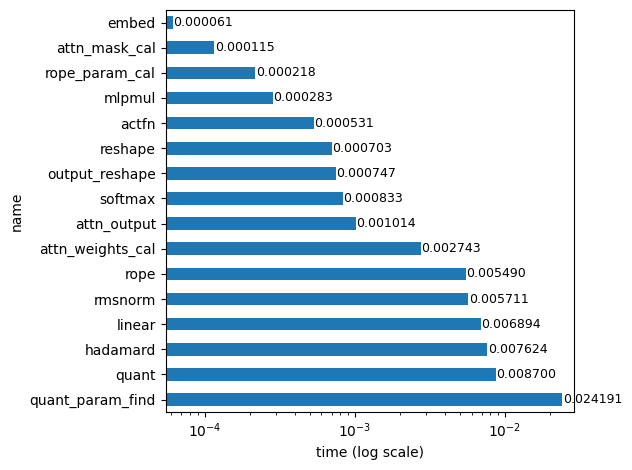

GENERATE: bs 1, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0666694641113 0.0603253841400
top.apply_rope                                                                   32         0.0223345756531 0.0170967578888
top.vproj                                                                        32         0.0130078792572 0.0108180046082
top.apply_rope.k_head_quantize                                                   32         0.0127491950989 0.0107016563416
top.apply_rope.k_head_quantize.find_params                                       32         0.0083994865417 0.0000000000000
top.vproj.find_params                                                            32         0.0078063011169 0.0071649551392
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


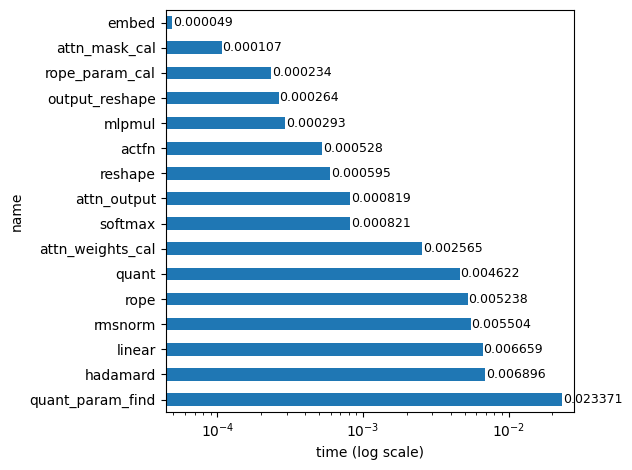

GENERATE: bs 1, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0680449008942 0.0615572929382
top.apply_rope                                                                   32         0.0228276252747 0.0175218582153
top.vproj                                                                        32         0.0132017135620 0.0109562873840
top.apply_rope.k_head_quantize                                                   32         0.0130953788757 0.0107934474945
top.apply_rope.k_head_quantize.find_params                                       32         0.0084197521210 0.0000000000000
top.vproj.find_params                                                            32         0.0078985691071 0.0072355270386
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


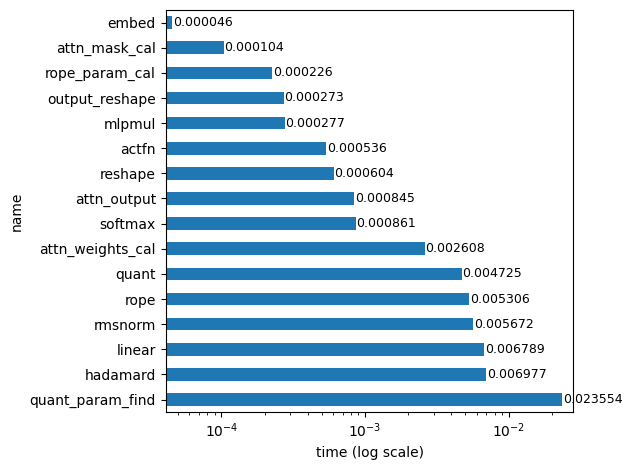

GENERATE: bs 1, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0673737525940 0.0609328746796
top.apply_rope                                                                   32         0.0225183963776 0.0172364711761
top.vproj                                                                        32         0.0130827426910 0.0108878612518
top.apply_rope.k_head_quantize                                                   32         0.0128366947174 0.0107669830322
top.apply_rope.k_head_quantize.find_params                                       32         0.0084154605865 0.0000000000000
top.vproj.find_params                                                            32         0.0078489780426 0.0071978569031
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


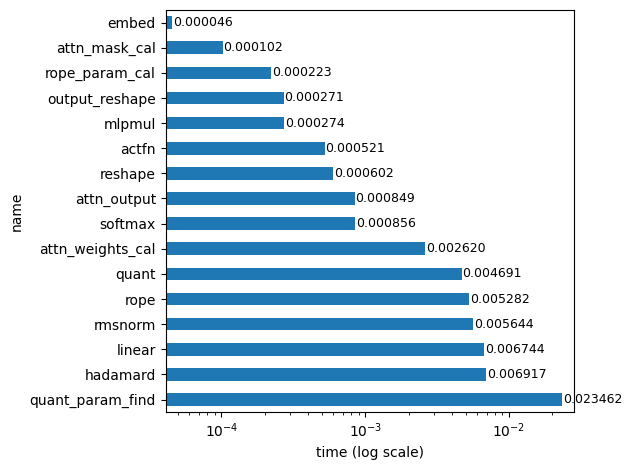

GENERATE: bs 1, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0670931339264 0.0606822967529
top.apply_rope                                                                   32         0.0224447250366 0.0171711444855
top.vproj                                                                        32         0.0130906105042 0.0108819007874
top.apply_rope.k_head_quantize                                                   32         0.0128223896027 0.0107643604279
top.apply_rope.k_head_quantize.find_params                                       32         0.0084166526794 0.0000000000000
top.vproj.find_params                                                            32         0.0078451633453 0.0071909427643
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


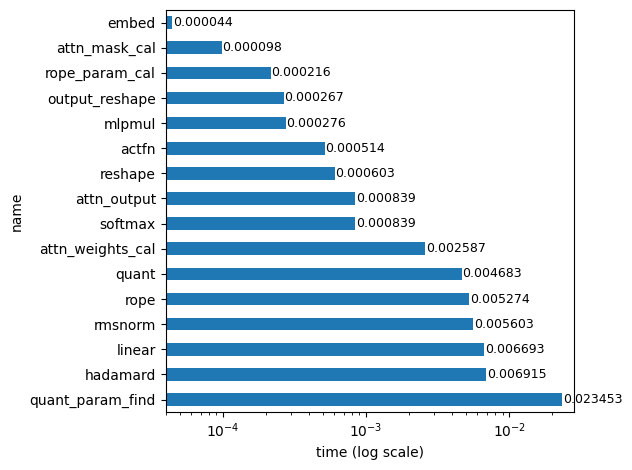

GENERATE: bs 1, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0685033798218 0.0613625049591
top.apply_rope                                                                   32         0.0226058959961 0.0173296928406
top.vproj                                                                        32         0.0132486820221 0.0110280513763
top.apply_rope.k_head_quantize                                                   32         0.0129253864288 0.0108134746552
top.apply_rope.k_head_quantize.find_params                                       32         0.0084636211395 0.0000000000000
top.vproj.find_params                                                            32         0.0079238414764 0.0072569847107
top.vproj.find_params.find_params_per_token_groupwise                           

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


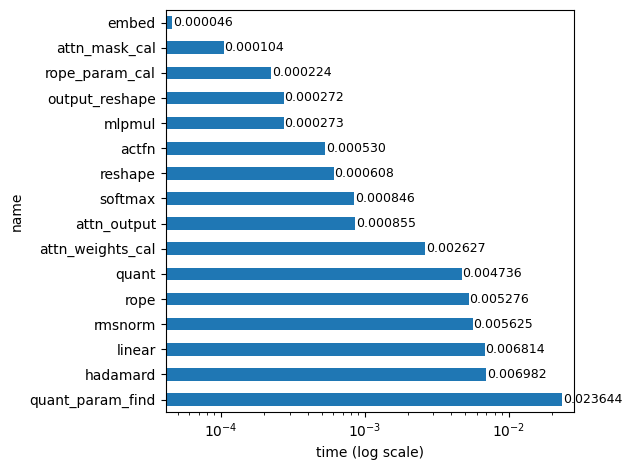

PREFILL: bs 2, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0734722614288 0.0676476955414
top.apply_rope                                                                   32         0.0250954627991 0.0194373130798
top.vproj                                                                        32         0.0141437053680 0.0118088722229
top.apply_rope.k_head_quantize                                                   32         0.0138647556305 0.0116748809814
top.apply_rope.k_head_quantize.find_params                                       32         0.0091588497162 0.0000000000000
top.vproj.find_params                                                            32         0.0084378719330 0.0077466964722
top.vproj.find_params.find_params_per_token_groupwise                            32

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


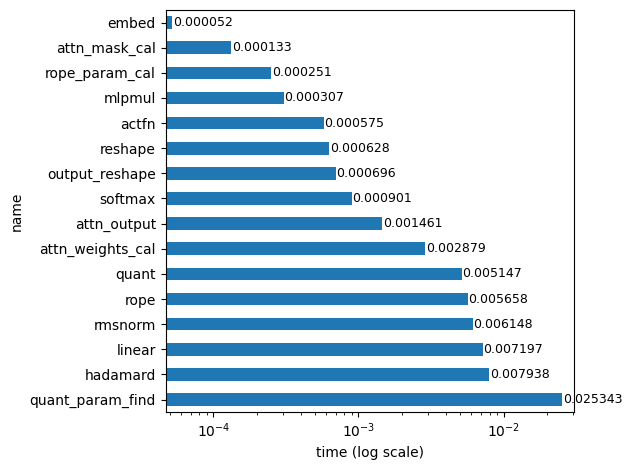

PREFILL: bs 2, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0758001804352 0.0698592662811
top.apply_rope                                                                   32         0.0249674320221 0.0193176269531
top.vproj                                                                        32         0.0142021179199 0.0118670463562
top.apply_rope.k_head_quantize                                                   32         0.0138292312622 0.0116341114044
top.apply_rope.k_head_quantize.find_params                                       32         0.0091481208801 0.0000000000000
top.downproj                                                                     32         0.0089945793152 0.0081541538239
top.vproj.find_params                                                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


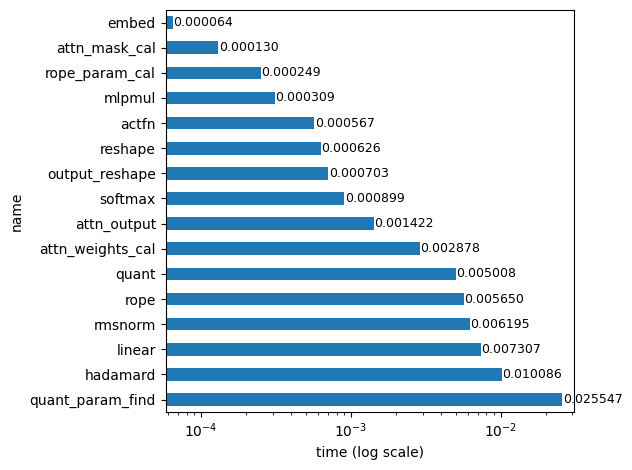

PREFILL: bs 2, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0770194530487 0.0710477828979
top.apply_rope                                                                   32         0.0278160572052 0.0220310688019
top.apply_rope.k_head_quantize                                                   32         0.0165505409241 0.0141601562500
top.vproj                                                                        32         0.0143160820007 0.0119690895081
top.apply_rope.k_head_quantize.find_params                                       32         0.0095739364624 0.0000000000000
top.vproj.find_params                                                            32         0.0086131095886 0.0079052448273
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


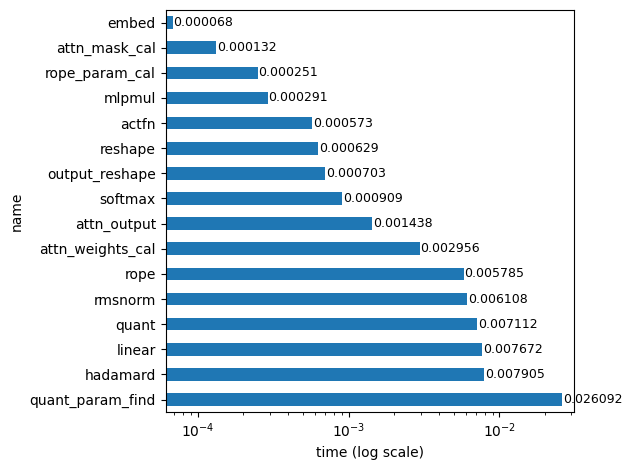

PREFILL: bs 2, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0788078308105 0.0728769302368
top.apply_rope                                                                   32         0.0254409313202 0.0196287631989
top.vproj                                                                        32         0.0186965465546 0.0160884857178
top.apply_rope.k_head_quantize                                                   32         0.0140082836151 0.0117795467377
top.apply_rope.k_head_quantize.find_params                                       32         0.0092625617981 0.0000000000000
top.vproj.find_params                                                            32         0.0085773468018 0.0078835487366
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


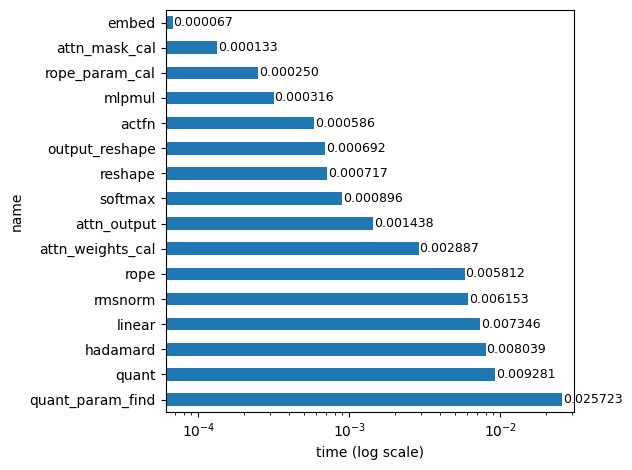

PREFILL: bs 2, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0899202823639 0.0840528011322
top.vproj                                                                        32         0.0275540351868 0.0252015590668
top.apply_rope                                                                   32         0.0260088443756 0.0203435420990
top.vproj.asmy_ste_quantize                                                      32         0.0156612396240 0.0000000000000
top.apply_rope.k_head_quantize                                                   32         0.0148484706879 0.0126256942749
top.apply_rope.k_head_quantize.find_params                                       32         0.0096364021301 0.0000000000000
top.vproj.find_params                                                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


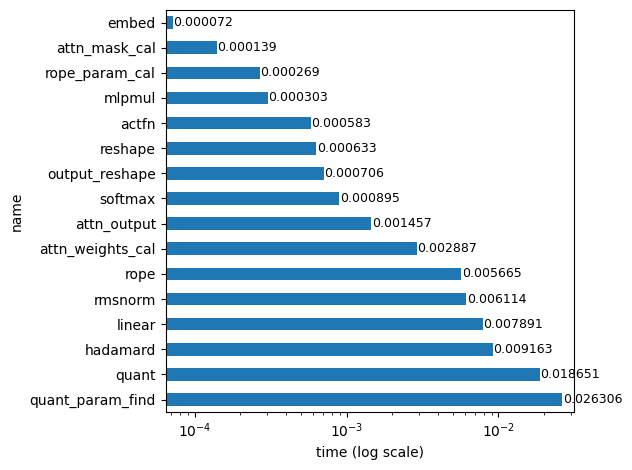

GENERATE: bs 2, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0720951557159 0.0652618408203
top.apply_rope                                                                   32         0.0242061614990 0.0186526775360
top.apply_rope.k_head_quantize                                                   32         0.0140166282654 0.0118403434753
top.vproj                                                                        32         0.0139675140381 0.0116410255432
top.apply_rope.k_head_quantize.find_params                                       32         0.0093131065369 0.0000000000000
top.vproj.find_params                                                            32         0.0083763599396 0.0076813697815
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


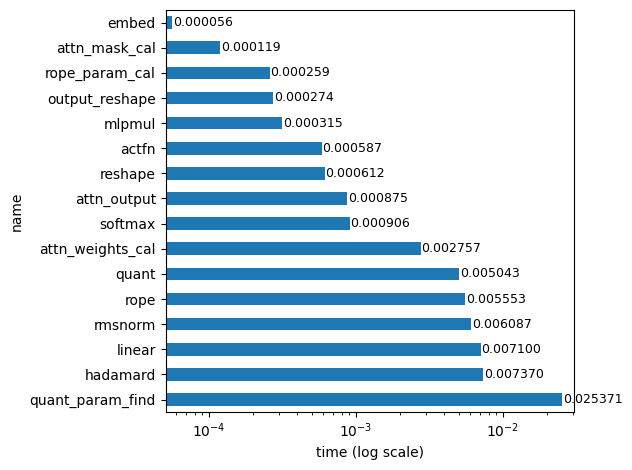

GENERATE: bs 2, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0712995529175 0.0645859241486
top.apply_rope                                                                   32         0.0237283706665 0.0182113647461
top.vproj                                                                        32         0.0138814449310 0.0115883350372
top.apply_rope.k_head_quantize                                                   32         0.0136299133301 0.0114669799805
top.apply_rope.k_head_quantize.find_params                                       32         0.0089683532715 0.0000000000000
top.vproj.find_params                                                            32         0.0083606243134 0.0076632499695
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


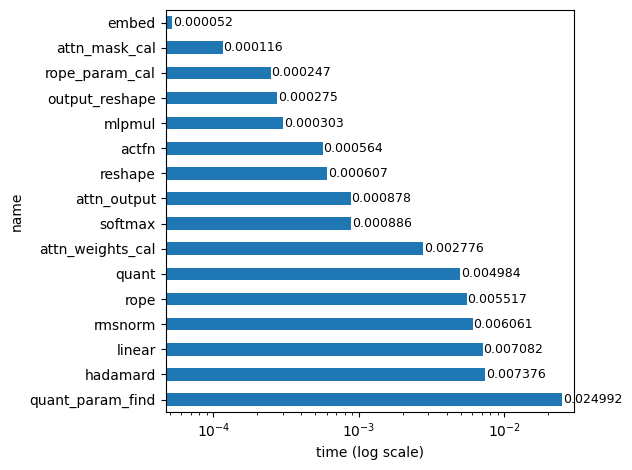

GENERATE: bs 2, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0713582038879 0.0645282268524
top.apply_rope                                                                   32         0.0237250328064 0.0181891918182
top.vproj                                                                        32         0.0138931274414 0.0116007328033
top.apply_rope.k_head_quantize                                                   32         0.0136020183563 0.0114417076111
top.apply_rope.k_head_quantize.find_params                                       32         0.0089428424835 0.0000000000000
top.vproj.find_params                                                            32         0.0083484649658 0.0076608657837
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


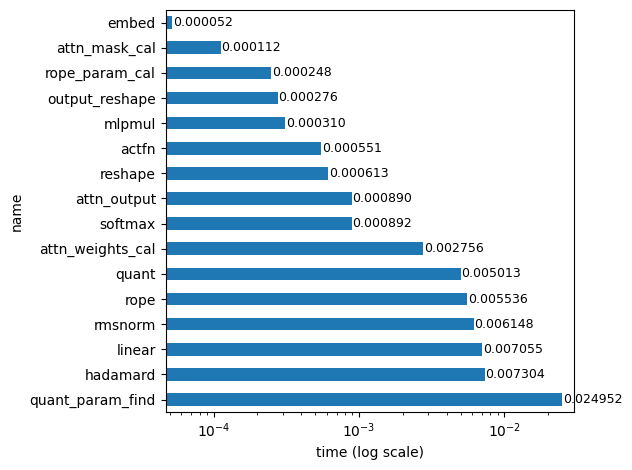

GENERATE: bs 2, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0718522071838 0.0649027824402
top.apply_rope                                                                   32         0.0238022804260 0.0182213783264
top.vproj                                                                        32         0.0139844417572 0.0116732120514
top.apply_rope.k_head_quantize                                                   32         0.0136594772339 0.0114796161652
top.apply_rope.k_head_quantize.find_params                                       32         0.0089964866638 0.0000000000000
top.vproj.find_params                                                            32         0.0083775520325 0.0076863765717
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


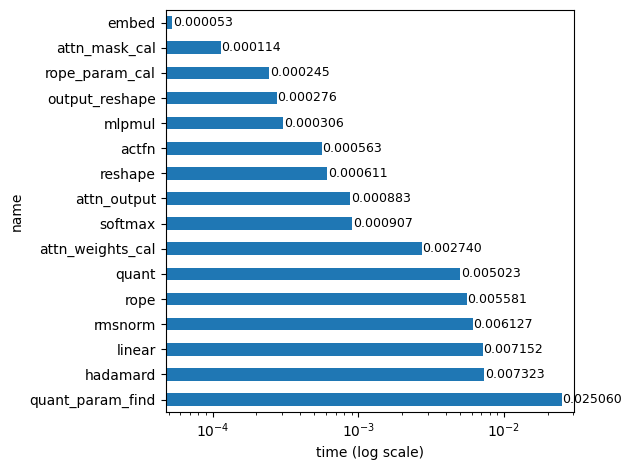

GENERATE: bs 2, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0787892341614 0.0712778568268
top.apply_rope                                                                   32         0.0243639945984 0.0187070369720
top.vproj                                                                        32         0.0187888145447 0.0118901729584
top.apply_rope.k_head_quantize                                                   32         0.0139441490173 0.0116291046143
top.apply_rope.k_head_quantize.find_params                                       32         0.0090942382812 0.0000000000000
top.vproj.find_params                                                            32         0.0085163116455 0.0077638626099
top.vproj.find_params.find_params_per_token_groupwise                           

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


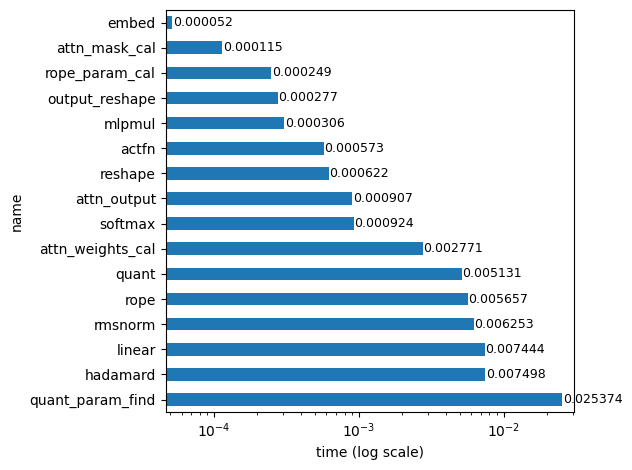

PREFILL: bs 4, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0738565921783 0.0678369998932
top.apply_rope                                                                   32         0.0250806808472 0.0194115638733
top.vproj                                                                        32         0.0141961574554 0.0118298530579
top.apply_rope.k_head_quantize                                                   32         0.0139319896698 0.0117094516754
top.apply_rope.k_head_quantize.find_params                                       32         0.0091974735260 0.0000000000000
top.vproj.find_params                                                            32         0.0084989070892 0.0077972412109
top.vproj.find_params.find_params_per_token_groupwise                            32

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


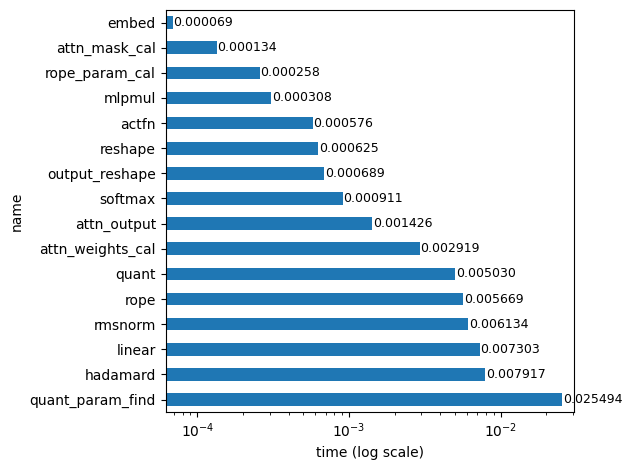

PREFILL: bs 4, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0736570358276 0.0677692890167
top.apply_rope                                                                   32         0.0249574184418 0.0192999839783
top.vproj                                                                        32         0.0142042636871 0.0118639469147
top.apply_rope.k_head_quantize                                                   32         0.0137882232666 0.0115952491760
top.apply_rope.k_head_quantize.find_params                                       32         0.0090920925140 0.0000000000000
top.vproj.find_params                                                            32         0.0084967613220 0.0078058242798
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


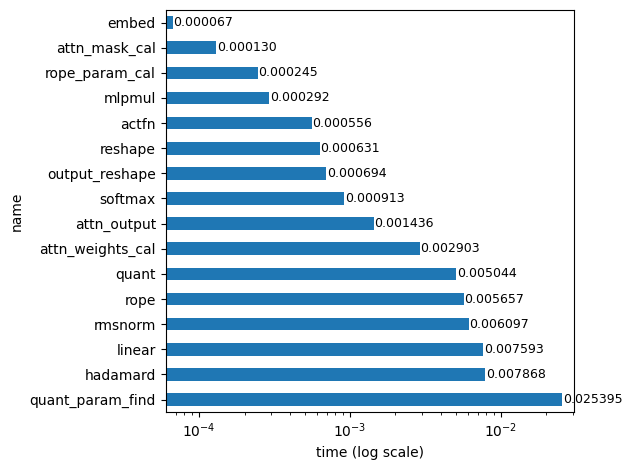

PREFILL: bs 4, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0740184783936 0.0679605007172
top.apply_rope                                                                   32         0.0250713825226 0.0193865299225
top.vproj                                                                        32         0.0142121315002 0.0118620395660
top.apply_rope.k_head_quantize                                                   32         0.0139293670654 0.0117061138153
top.apply_rope.k_head_quantize.find_params                                       32         0.0092098712921 0.0000000000000
top.vproj.find_params                                                            32         0.0085325241089 0.0078282356262
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


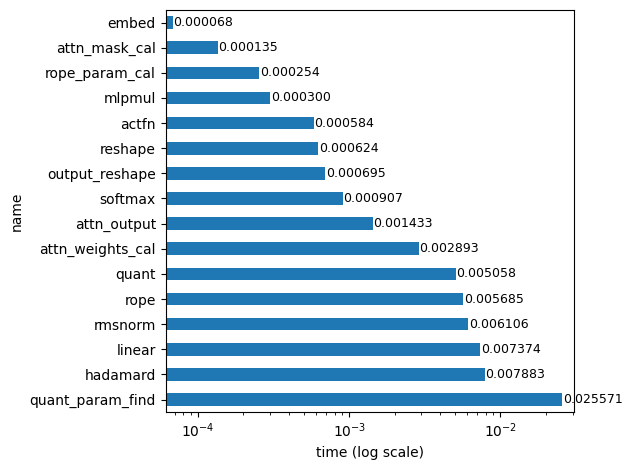

PREFILL: bs 4, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0894627571106 0.0834770202637
top.vproj                                                                        32         0.0274102687836 0.0250842571259
top.apply_rope                                                                   32         0.0258471965790 0.0201795101166
top.vproj.asmy_ste_quantize                                                      32         0.0155906677246 0.0000000000000
top.apply_rope.k_head_quantize                                                   32         0.0147130489349 0.0124976634979
top.apply_rope.k_head_quantize.find_params                                       32         0.0092177391052 0.0000000000000
top.vproj.find_params                                                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


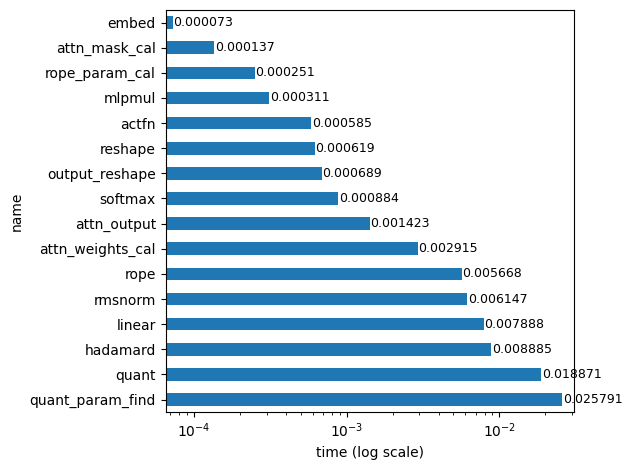

PREFILL: bs 4, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.1238698959351 0.1178231239319
top.vproj                                                                        32         0.0578303337097 0.0554199218750
top.vproj.asmy_ste_quantize                                                      32         0.0458660125732 0.0000000000000
top.apply_rope                                                                   32         0.0274980068207 0.0218069553375
top.apply_rope.k_head_quantize                                                   32         0.0162951946259 0.0140671730042
top.downproj                                                                     32         0.0102860927582 0.0093698501587
top.apply_rope.k_head_quantize.find_params                                       

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


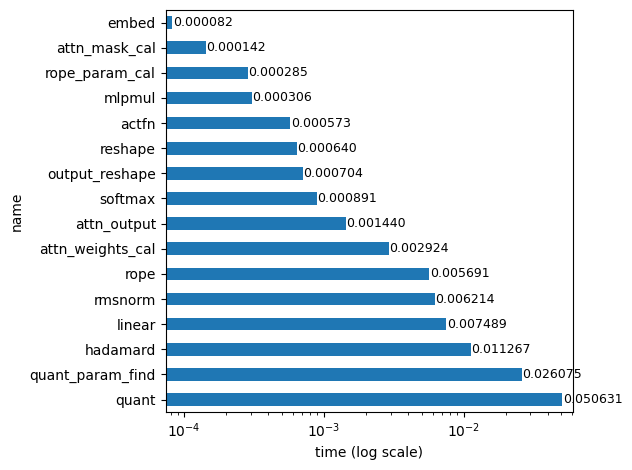

GENERATE: bs 4, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0725295543671 0.0656538009644
top.apply_rope                                                                   32         0.0244076251984 0.0189020633698
top.apply_rope.k_head_quantize                                                   32         0.0142414569855 0.0120239257812
top.vproj                                                                        32         0.0140399932861 0.0117144584656
top.apply_rope.k_head_quantize.find_params                                       32         0.0094790458679 0.0000000000000
top.vproj.find_params                                                            32         0.0084547996521 0.0077259540558
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


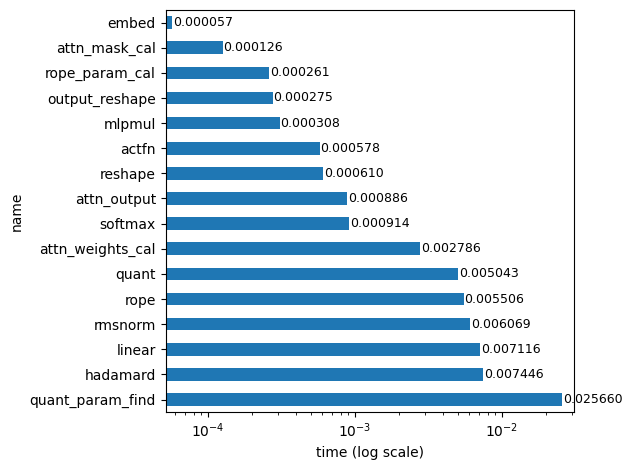

GENERATE: bs 4, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0759608745575 0.0661373138428
top.apply_rope                                                                   32         0.0244047641754 0.0188345909119
top.apply_rope.k_head_quantize                                                   32         0.0141525268555 0.0116336345673
top.vproj                                                                        32         0.0140852928162 0.0117485523224
top.apply_rope.k_head_quantize.find_params                                       32         0.0090723037720 0.0000000000000
top.vproj.find_params                                                            32         0.0084629058838 0.0077481269836
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


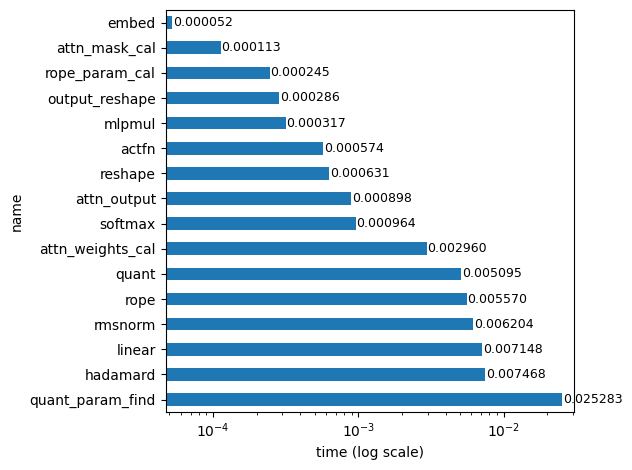

GENERATE: bs 4, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0713870525360 0.0645802021027
top.apply_rope                                                                   32         0.0237789154053 0.0182592868805
top.vproj                                                                        32         0.0138735771179 0.0115766525269
top.apply_rope.k_head_quantize                                                   32         0.0136456489563 0.0114779472351
top.apply_rope.k_head_quantize.find_params                                       32         0.0089671611786 0.0000000000000
top.vproj.find_params                                                            32         0.0083215236664 0.0076339244843
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


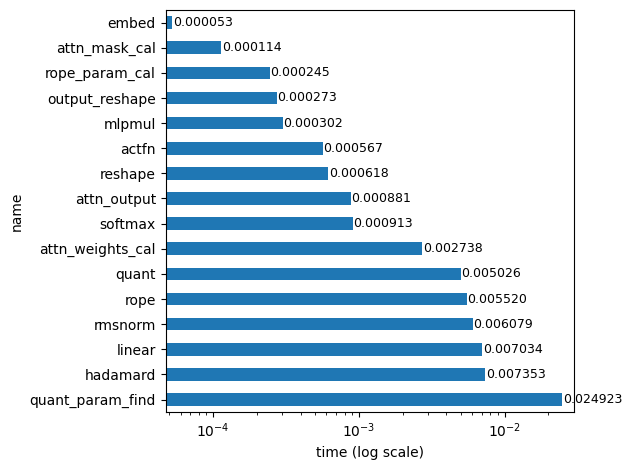

GENERATE: bs 4, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0715265274048 0.0646672248840
top.apply_rope                                                                   32         0.0237731933594 0.0182111263275
top.vproj                                                                        32         0.0139086246490 0.0116074085236
top.apply_rope.k_head_quantize                                                   32         0.0136296749115 0.0114338397980
top.apply_rope.k_head_quantize.find_params                                       32         0.0089573860168 0.0000000000000
top.vproj.find_params                                                            32         0.0083544254303 0.0076589584351
top.vproj.find_params.find_params_per_token_groupwise                            

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


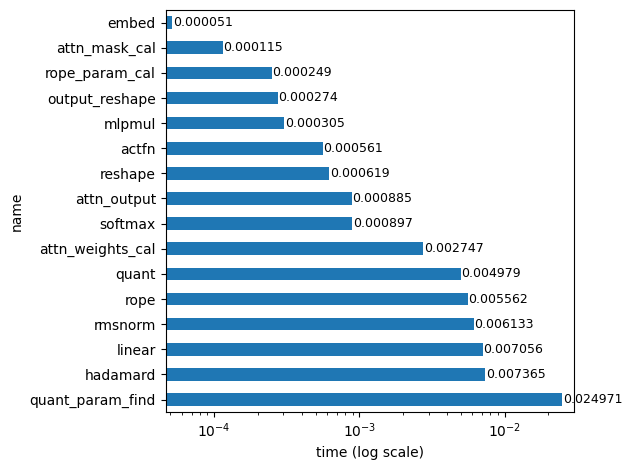

GENERATE: bs 4, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0749976634979 0.0678966045380
top.apply_rope                                                                   32         0.0265514850616 0.0209300518036
top.apply_rope.k_head_quantize                                                   32         0.0162556171417 0.0140230655670
top.vproj                                                                        32         0.0141212940216 0.0117833614349
top.apply_rope.k_head_quantize.find_params                                       32         0.0114161968231 0.0000000000000
top.vproj.find_params                                                            32         0.0084838867188 0.0077862739563
top.vproj.find_params.find_params_per_token_groupwise                           

/home/donghweeson/workspace/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


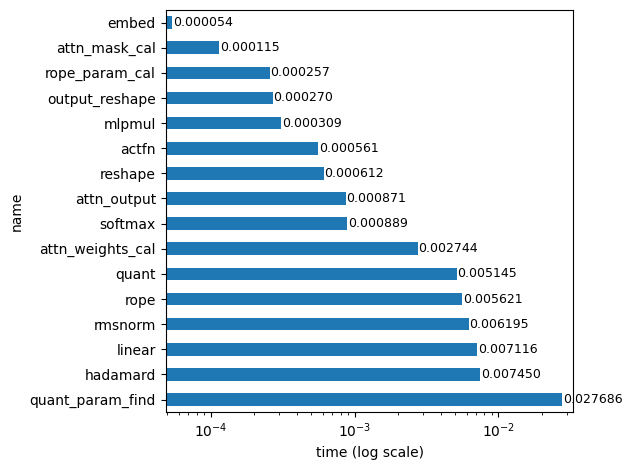

In [19]:
batch_size = [1, 2, 4]
past_seq_len = [8, 16, 32, 64, 128]
seq_len = [8, 16, 32, 64, 128]

for bs in batch_size:
  # prefill
  for sl in seq_len:
    print(f"PREFILL: bs {bs}, sl {sl}")
    run_profile(model, bs, 0, sl, "cuda", f"./prof/bs{bs}_sl{sl}_prf-cuda.png") 
  
  # generate
  for sl in past_seq_len:
    print(f"GENERATE: bs {bs}, sl {sl}")
    run_profile(model, bs, sl, 1, "cuda", f"./prof/bs{bs}_sl{sl}_gen-cuda.png")